# <center>Introduction to Machine Learning</center>
# <center>Final Project</center>
<center>Victor DUC</center>
<center>April 6, 2023</center>

<p style="text-align: justify;">
This notebook presents several classification (supervised learning) and clustering (unsupervised learning) models. Although in reality, the first step of data preprocessing <em>i.e.</em> data cleaning (handling missing data, noisy data, duplicate data, outlier detection and removal) and data transformation (feature selection...) is crucial (and time consuming), we will use an artificial dataset and go directly to the construction of machine learning models. Following what has been done in class, we will try to illustrate our results as much as possible. In order not to make this notebook too long, we will hide some code cells used only for plotting graphics (which are often long and not very interesting). We will state the definitions of certain concepts not covered in class and will systematically add the corresponding references to the Scikit-Learn website.
</p>

---

## Table of contents

[<font size="4"><strong>1 &thinsp; Discover and visualize the data to gain insights</strong></font>](#chapter1) <br> 
[<font size="4"><strong>2 &thinsp; Binary classification </strong></font>](#chapter2) <br> 
&emsp; [<strong>2.1 One feature (LogisticRegression)</strong>](#section_2_1) <br>
&emsp;&emsp; [2.1.1 Decision boundary](#section_2_1_1) <br>
&emsp;&emsp; [2.1.2 Accuracy](#section_2_1_2) <br>
&emsp;&emsp; [2.1.3 Precision/Recall Trade-off](#section_2_1_3) <br>
&emsp; [<strong>2.2 Two features (LogisticRegression and LinearSVC)</strong>](#section_2_2) <br>
&emsp;&emsp; [2.2.1 LogisticRegression](#section_2_2_1) <br>
&emsp;&emsp; [2.2.1 LinearSVC](#section_2_2_2) <br>
[<font size="4"><strong>3 &thinsp; Multiclass classification</strong></font>](#chapter3) <br> 
&emsp; [<strong>3.1 Model 1 - Batch Gradient Descent with early stopping for Softmax Regression (from scratch)</strong>](#section_3_1) <br>
&emsp; [<strong>3.2 Model 2 - SVM classification</strong>](#section_3_2) <br>
&emsp; [<strong>3.3 Overview of $k$-Nearest Neighbors and DecisionTreeClassifier</strong>](#section_3_3) <br>
[<font size="4"><strong>4 &thinsp; Clustering</strong></font>](#chapter4) <br> 
&emsp; [<strong>4.1 $K$-Means Clustering </strong>](#section_4_1) <br>
&emsp;&emsp; [4.1.1 Number of clusters given](#section_4_1_1) <br>
&emsp;&emsp; [4.1.2 Number of clusters not given](#section_4_1_2) <br>
&emsp;&emsp;&emsp; [4.1.2.1 Inertia as a function of $k$](#section_4_1_2_1) <br>
&emsp;&emsp;&emsp; [4.1.2.2 Silhouette Score](#section_4_1_2_2) <br>
&emsp; [<strong>4.2 Further consideration - Gaussian mixture </strong>](#section_4_2) <br>

---

We begin with the standard imports.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

To ensure that this notebook's outputs remain the same every time we run it, we need to set the random seed.

In [2]:
seed=3
np.random.seed(seed)

To fine-tune our models we will need the following imports.

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In contrast to ```GridSearchCV```, in ```RandomizedSearchCV``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)) not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. One benefit is that a computation budget (being the number of sampled candidates) can be chosen independent of the number of parameters and possible values.

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search).

# 1     Discover and visualize the data to gain insights <a class="anchor" id="chapter1"></a>

The ```sklearn.datasets.make_blobs``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs)) generator produces a matrix of features and corresponding discrete targets. More precisely it creates a multiclass dataset by allocating each class one or more normally-distributed and isotropic clusters of points. It provides a great control regarding the centers and standard deviations of each cluster and is used for clustering.

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

The following code creates 3 classes by generating 5 clusters with 2 features by default (```n_features=2```).

|                    | Class 0 | Class 1 | Class 2 |
| ------------------ | --------| ------- | ------- |
| Number of clusters |   1     |    1    |    3    |
| Number of points   |   100   |   100   |   150   |

In [4]:
from sklearn.datasets import make_blobs

# Generation of 3 classes (class 0, class 1, class 2), each class one cluster of n_samples/3 = 300/3 = 100 points
centers = [[0, -0.4], [-2, -3], [0.8, -1.8]]
cluster_std = [0.45, 0.30, 0.4]
X_gene, y_gene = make_blobs(n_samples=300, centers=centers, cluster_std=cluster_std, random_state=seed)

# Add 2 clusters for the class 2, one cluster with 18 points and the other cluster with 32 points
new_center = [[-0.6, 0.9], [-0.3, -1.8]]  
new_cluster_std = [0.35, 0.35]  
new_X, new_y = make_blobs(n_samples=[18, 32], centers=new_center, cluster_std=new_cluster_std, random_state=seed)

# Add the 2 new clusters for the class 2 to the existing dataset
X = np.concatenate([X_gene, new_X], axis=0)
y = np.concatenate([y_gene, np.full(50, 2)], axis=0) # add the lables of the new cluster points i.e. 18+32=50 times the label 2 

Although by default the parameter ```shuffle=True``` is applied, our 50 last points belongs to the class 2 so we need to shuffle the dataset. 

In [5]:
idx = np.random.permutation(X.shape[0])
X = X[idx]
y = y[idx]

Let's display the last 5 values and the shape of the variables to be sure of what we are handling.

In [6]:
X[:5]

array([[ 0.55589986, -1.79751195],
       [-0.32221161, -0.07084042],
       [ 0.43407112, -2.15885591],
       [-1.96332508, -3.34721501],
       [-1.44825443, -2.30524242]])

In [7]:
y[:5]

array([2, 0, 2, 1, 1])

In [8]:
print('X.shape :', X.shape)
print('y.shape :', y.shape)

X.shape : (350, 2)
y.shape : (350,)


Let's standardize features by removing the mean and scaling to unit variance (because models used are sensitive to the scale of
the input features).

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X) # equivalent to X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

First of all let's split our data into two sets : the training set and the test set.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed) # test_size=0.25 by default

Let's display explicitly the dimensions of our variables.

In [11]:
print('X_train.shape :', X_train.shape)
print('X_test.shape :', X_test.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)

X_train.shape : (262, 2)
X_test.shape : (88, 2)
y_train.shape : (262,)
y_test.shape : (88,)


By default data is not split in a stratified fashion (```stratify=None```) but some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. In such cases it is recommended to use stratified sampling. Here there should be no need for it but as we consider a small data set let's check anyway the values in ```y_train```. 

In [12]:
unique_values, counts = np.unique(y_train, return_counts=True)
for i in range(len(unique_values)):
    print("Value ", unique_values[i], " : ", counts[i], "occurrences")

Value  0  :  77 occurrences
Value  1  :  75 occurrences
Value  2  :  110 occurrences


In this notebook we will denote $x_1$ and $x_2$ the features *i.e.* $X=(x_1\,|\,x_2)\in\mathbb{R}^{350 \times 2}$.

Text(0.5, 1.0, 'Plot of the training set used in this notebook')

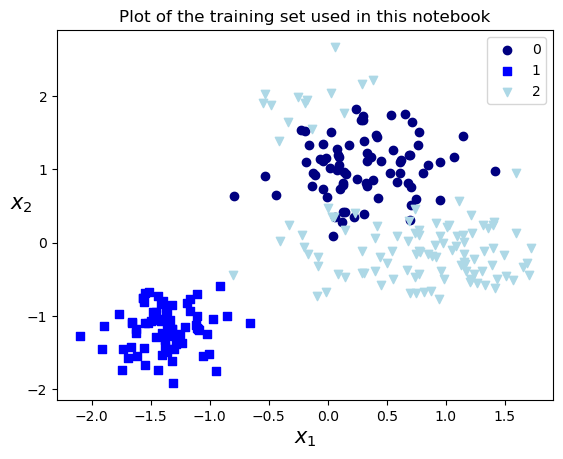

In [13]:
def plot_train_dataset():
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], marker='o', color = 'navy', label='0')
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], marker='s', color='blue', label='1')
    plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1], marker='v', color='lightblue', label='2')
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15, rotation=0)

def plot_dataset():
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='o', color = 'navy', label='0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='s', color='blue', label='1')
    plt.scatter(X[y == 2, 0], X[y == 2, 1], marker='v', color='lightblue', label='2')
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15, rotation=0)

plot_train_dataset()
plt.legend()
plt.title('Plot of the training set used in this notebook')

As we are not working with a skewed dataset we can use the accuracy as the performance measure of our classifiers. It is implemented in ```sklearn.metrics.accuracy_score``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)) and computes by default the fraction of correct predictions (```normalize=True```). 

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

In [14]:
from sklearn.metrics import accuracy_score

We will evaluate the ```accuracy_score``` by cross-validation.

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# 2    Binary Classification<a class="anchor" id="chapter2"></a>

As we are mainly interested into classes 0 and 2, let's first do binary classification and build a 2-detector capable of
distinguishing between just two classes, 2 and not-2.

In [16]:
y_train_2 = y_train==2
y_test_2 = y_test==2

Let’s look at a dumb classifier which makes predictions that ignore the input features. This classifier serves as a simple baseline to compare against other more complex classifiers.

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier() # by default strategy='prior' : the predict method always returns the most frequent class
dummy_clf.fit(X_train, y_train_2)
cross_val_score(dummy_clf, X_train, y_train_2, cv=5, scoring='accuracy').mean()

0.5801161103047894

<div class="alert alert-block alert-info">
<b>Score.</b> 
    0.58
</div>

Although the dataset is not linearly separable, let's start by building some linear classification models. They will allow us to obtain other reference values for the performance of models and to introduce some theoretical notions.

## 2.1 One feature (LogisticRegression) <a class="anchor" id="section_2_1"></a>

Let us first look at the first feature $x_1$. 

In [18]:
X_train_1 = X_train[:,0].reshape(-1,1)

In [19]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=seed) # by default penalty='l2', C=1, solver='lbfgs'
log_reg.fit(X_train_1, y_train_2)

LogisticRegression(random_state=3)

### 2.1.1 Decision boundary <a class="anchor" id="section_2_1_1"></a>

Looking at the graph of the dataset, we expect the decision boundary to be close to $x_1=0.3$ (since most of the points of class 2 verifiy $x_1\geqslant 0.3$). 

In [20]:
X_new = np.linspace(-2, 2, 1000).reshape(-1, 1)  
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]
decision_boundary

0.3463463463463463

(-1.0, 2.0, 0.0, 1.0)

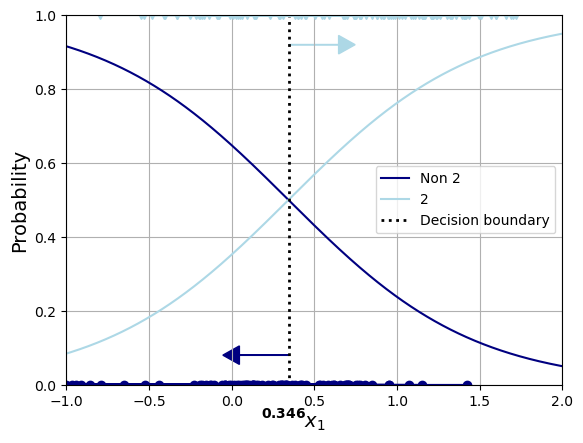

In [21]:
plt.plot(X_new, y_proba[:,0], color='navy', label='Non 2')
plt.plot(X_new, y_proba[:,1], color='lightblue', label='2')
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2, label="Decision boundary")

# The following lines are only used to adorn and annotate the graph
plt.text(decision_boundary-0.03, -0.09, fr"$\mathbf{{{decision_boundary:.3f}}}$", ha="center", fontsize=10)
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0, head_width=0.05, head_length=0.1, fc='navy', ec='navy')
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0, head_width=0.05, head_length=0.1, fc='lightblue', ec='lightblue')
plt.plot(X_train_1[y_train_2 == False], np.zeros(len(X_train_1[y_train_2 == False])), marker='o', color = 'navy')
plt.plot(X_train_1[y_train_2 == True], np.ones(len(X_train_1[y_train_2 == True])), marker='v', color = 'lightblue')
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center right", fontsize=10)
plt.grid()
plt.axis([-1, 2, 0, 1])

### 2.1.2 Accuracy <a class="anchor" id="section_2_1_2"></a>

Looking at the graphical representation of the dataset, we expect the performance to be quite poor since the feature $x_1$ does not separate the classes.

In [22]:
cross_val_score(log_reg, X_train_1, y_train_2, scoring="accuracy", cv=5).mean()

0.7443396226415094

<div class="alert alert-block alert-info">
<b>Score.</b> 
    0.74
</div>

Let's compare this score using cross-validation (the validation error) with the score measured on the training set (the training error).

In [23]:
log_reg_predictions = log_reg.predict(X_train_1)
accuracy_score(log_reg_predictions, y_train_2)

0.7557251908396947

The training score is not much better than the validation score so the model seems not to overfit the training set. Indeed the complexity of the model is not sufficient, so there is no overfitting but rather underfitting.

In [24]:
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(log_reg, X_train_1, y_train_2, cv=5) 
cm = confusion_matrix(y_train_2, y_train_pred)
cm

array([[118,  34],
       [ 33,  77]], dtype=int64)

Recall the structure of a confusion matrix.

|    |    |
| -  | -  |
| $TN$ | $FP$ |
| $FN$ | $TP$ |

Even if the confusion matrix gives a lot of information, let's introduce more concise metric. Intuitively, 
- precision, implemented in ```sklearn.metrics.precision_score``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)), is the ability of the classifier not to label as positive a sample that is negative
- recall, implemented in ```sklearn.metrics.recall_score``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)), is the ability of the classifier to find all the positive samples.

<div class="alert alert-block alert-warning">
<b>Definition.</b> <br> 
    <ul>
        <li> The <strong>precision</strong> or <strong>accuracy of the positive predictions</strong> is defined by
            $$\text{precision}=\frac{TP}{TP+FP}$$
        </li>
        <li> The <strong>recall</strong> or <strong>sensitivity</strong> or <strong>true positive rate (TPR)</strong> is defined by
            $$\text{recall}=\frac{TP}{TP+FN}$$
        </li>
    </ul>
</div>

- A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. In particular, a classifier that always predicts the positive class verifies:
$$\text{precision}=\frac{P}{P+N}\qquad \text{and}\qquad \text{recall}=1$$
- A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. 

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

In [25]:
from sklearn.metrics import precision_score, recall_score

print('Precision : ', round(precision_score(y_train_2, y_train_pred),3)) 
print('Recall : ', round(recall_score(y_train_2, y_train_pred),3)) 

Precision :  0.694
Recall :  0.7


These values are obtained directly from the confusion matrix as follows.

In [26]:
print(round(cm[1, 1] / (cm[0, 1] + cm[1, 1]),3))
print(round(cm[1, 1] / (cm[1, 0] + cm[1, 1]),3))

0.694
0.7


Sometimes we may prefer to combine precision and recall by computing the $F_1$ score implemented in ```sklearn.metrics.f1_score``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)). 

<div class="alert alert-block alert-warning">
<b>Definition.</b> <br> 
    The <strong>$F_1$ score</strong> is the harmonic mean of the precision and the recall.
    $$F_1=\frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}=2\frac{\text{precision}*\text{recall}}{\text{precision}+\text{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$$
</div>

The relative contribution of precision and recall to the $F_1$ score are equal but the harmonic gives more weight to low values than the regular mean.

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics).

In [27]:
from sklearn.metrics import f1_score

round(f1_score(y_train_2, y_train_pred),3)

0.697

This value is obtained directly from the confusion matrix as follows.

In [28]:
round(cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2),3)

0.697

The $F_1$ score favors classifiers that have similar precision and recall ; this is not always
what we want. If we suppose we are training a classifier to detect cancerous tumors we really care about recall which catch all bad medical images (even if it means sometimes false alarms $FP \nearrow$). In this case we should rather use the $F_\beta$ score with $\beta>1$ to obtain a weighted harmonic mean. 

#### 2.1.3 Precision/Recall Trade-off <a class="anchor" id="section_2_1_3"></a>

There is a trade-off to do between precision and recall. Let us first recall that the ```decision_function``` method returns a
score for each instance.

In [29]:
new_point = [0.3]
new_point_score = log_reg.decision_function([new_point])
print(new_point_score)

[-0.076737]


As the ```LogisticRegression``` classifier uses a threshold equal to 0 and $-0.07<0$, it predicts that the new point is not in class 2.

In [30]:
log_reg.predict([new_point])

array([False])

The Precision Recall curve, implemented in ```sklearn.metrics.precision_recall_curve``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)), computes precision-recall pairs for different probability decision thresholds. 
> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

In [31]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(log_reg, X_train_1, y_train_2, cv=5, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

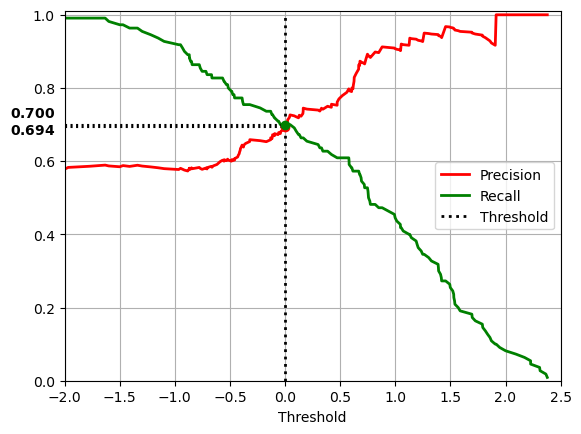

In [32]:
threshold = 0
plt.plot(thresholds, precisions[:-1], "r-", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

# The following lines are only used to adorn and annotate the graph
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="Threshold", linewidth=2)
plt.plot([-2, 0], [precision_score(y_train_2, y_train_pred), precision_score(y_train_2, y_train_pred)], color="k", linestyle="dotted") 
plt.plot([-2, 0], [recall_score(y_train_2, y_train_pred), recall_score(y_train_2, y_train_pred)], color="k", linestyle="dotted") 
plt.text(-2.29, precision_score(y_train_2, y_train_pred)-0.02, fr"$\mathbf{{{precision_score(y_train_2, y_train_pred):.3f}}}$", ha="center", fontsize=10)
plt.text(-2.29, recall_score(y_train_2, y_train_pred)+0.02, fr"$\mathbf{{{recall_score(y_train_2, y_train_pred):.3f}}}$", ha="center", fontsize=10)
plt.plot(0, precision_score(y_train_2, y_train_pred), "ro")
plt.plot(0, recall_score(y_train_2, y_train_pred), "go")
plt.axis([-2, 2.5, 0, 1.01])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

We can find our values of precision and recall by looking at the values at $0$.

In [33]:
index = np.abs(thresholds).argmin() 
print('Precision : ', round(precisions[index],2))
print('Recall :', round(recalls[index],2))

Precision :  0.69
Recall : 0.7


If we continue to suppose that we are training a classifier to detect cancerous tumors, we could set the treshold to $-0.5$. In this case the new point will be classified as class 2. 

In [34]:
threshold = -0.5
print(new_point_score>threshold)

[ True]


Decreasing the threshold increases the recall. We could choose the highest treshold that gives 90% recall.

In [35]:
print('Highest 90% recall threshold : ', round(thresholds[np.argmin(recalls >= 0.9)],3))

Highest 90% recall threshold :  -0.883


The average precision score, implemented in ```sklearn.metrics.average_precision_score``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)), summarizes a precision-recall curve.

<div class="alert alert-block alert-warning">
<b>Definition.</b> <br> 
    The <strong>average precision score</strong>, denoted $AP$, is the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.
    $$AP=\sum_{n}(R_n-R_{n-1})P_n$$
    where, for all threshold $n$,
    <ul>
        <li> $P_n$ is the precision at the $n$th threshold
        <li> $R_n$ is the recall at the $n$th threshold
    </ul>
</div>

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

In [36]:
from sklearn.metrics import average_precision_score

print('Average Precision Score AP :', round(average_precision_score(y_train_2,y_scores),3))

Average Precision Score AP : 0.816


This value is obtained directly from the Precision Recall curve as follows.

In [37]:
round(-np.sum(np.diff(recalls) * np.array(precisions)[:-1]),3)

0.816

A way to select a good precision/recall trade-off is to plot precision against recall. It's an alternative to the receiver operating characteristic (ROC) curve generally used when the positive class is rare or when we care more about the false positives than
the false negatives.

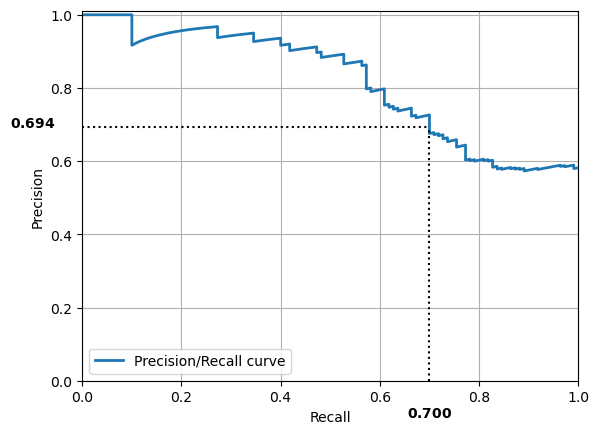

In [38]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# The following lines are only used to adorn and annotate the graph
plt.plot([recall_score(y_train_2, y_train_pred), recall_score(y_train_2, y_train_pred)], [0, precision_score(y_train_2, y_train_pred)], color="k", linestyle="dotted") 
plt.plot([0, recall_score(y_train_2, y_train_pred)], [precision_score(y_train_2, y_train_pred), precision_score(y_train_2, y_train_pred)], color="k", linestyle="dotted") 
plt.text(recall_score(y_train_2, y_train_pred), -0.1, fr"$\mathbf{{{recall_score(y_train_2, y_train_pred):.3f}}}$", ha="center", fontsize=10)
plt.text(-0.1, precision_score(y_train_2, y_train_pred), fr"$\mathbf{{{precision_score(y_train_2, y_train_pred):.3f}}}$", ha="center", fontsize=10)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.axis([0, 1, 0, 1.01])
plt.legend(loc="lower left")

As precision doesn't really starts to fall sharply at a certain value of the recall, the precision versus recall curve is not very useful here to choose the values. 

## 2.2 Two features (LogisticRegression and LinearSVC) <a class="anchor" id="section_2_2"></a>

Before to start multiclass classification, let's add the second feature $x_2$. 

### 2.2.1 LogisticRegression <a class="anchor" id="section_2_2_1"></a>

In [39]:
log_reg = LogisticRegression(random_state=seed)
log_reg.fit(X_train, y_train_2)

LogisticRegression(random_state=3)

(-0.5, 2.0, -2.0, 3.0)

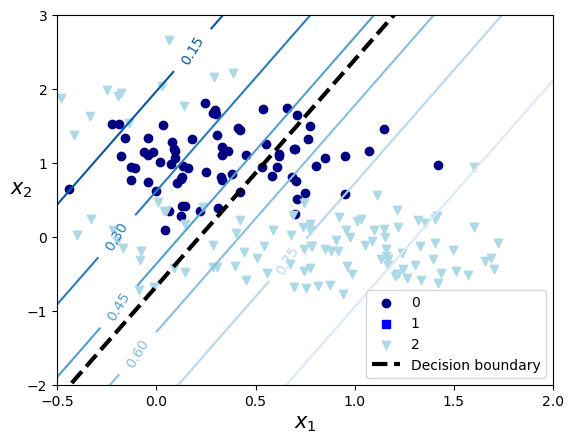

In [40]:
# For the contour plot
x0, x1 = np.meshgrid(np.linspace(-0.5, 2, 500).reshape(-1, 1),
                     np.linspace(-3, 3, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# For the decision boundary
left_right = np.array([-0.5, 2])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])/ log_reg.coef_[0, 1])

#
plot_train_dataset()
contour = plt.contour(x0, x1, zz, cmap='Blues_r')
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3, label='Decision boundary')
plt.legend(loc="lower right")
plt.axis([-0.5, 2, -2, 3])

Looking at the graphical representation of the dataset, we expect to gain little in performance (since the dataset is not linearly separable).

In [41]:
cross_val_score(log_reg, X_train, y_train_2, scoring="accuracy", cv=5).mean()

0.809288824383164

<div class="alert alert-block alert-info">
<b>Score.</b> 
    0.81
</div>

### 2.2.2 LinearSVC <a class="anchor" id="section_2_2_2"></a>

It is expected that a linear SVM classifier will obtain a performance close to that of our logistic regression. To show once again that the poor performance is not related to overfitting (although it is obvious) let's try to fine-tune our next model a bit.

In [42]:
from sklearn.svm import LinearSVC

linear_svm_clf = LinearSVC(max_iter=1e6, dual=False, random_state=seed) # by default loss='squared_hinge'

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 1, num=50)
}

grid_search = GridSearchCV(linear_svm_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train_2)
grid_search.best_estimator_

LinearSVC(C=0.3727593720314942, dual=False, max_iter=1000000.0, random_state=3)

(-0.5, 2.0, -3.0, 3.0)

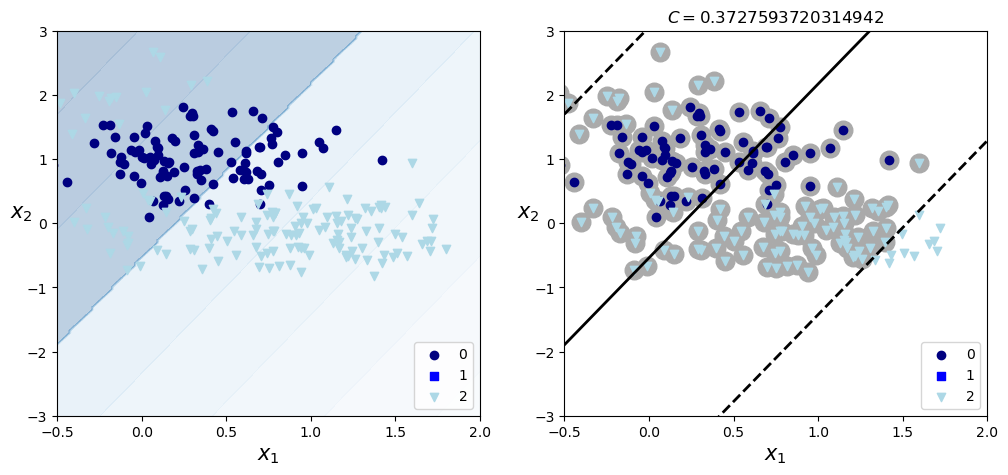

In [43]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    # At the margin, w0*x0 + w1*x1 + b = \pm 1
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 150)
    x1s = np.linspace(axes[2], axes[3], 150)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_train = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_train).reshape(x0.shape)
    y_decision = clf.decision_function(X_train).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap='Blues_r', alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap='Blues_r', alpha=0.1)

fig = plt.figure(figsize=(12, 5))

# Plot 1
ax1 = fig.add_subplot(121)
plot_predictions(grid_search.best_estimator_, [-0.5, 2, -3, 3])
plot_dataset()
ax1.legend(loc="lower right")
ax1.axis([-0.5, 2, -3, 3])

# Plot 2
ax2 = fig.add_subplot(122)
b1 = grid_search.best_estimator_.intercept_[0]
w1 = grid_search.best_estimator_.coef_[0] 
t = y_train_2 * 2 - 1
support_vectors_idx1 = (t * (X_train.dot(w1) + b1) < 1).ravel()
grid_search.best_estimator_.support_vectors_ = X_train[support_vectors_idx1]

plot_svc_decision_boundary(grid_search.best_estimator_, -0.5, 2)
plot_train_dataset()
ax2.legend(loc="lower right")
ax2.set_title(f"$C = {grid_search.best_estimator_.C}$")
ax2.axis([-0.5, 2, -3, 3])

Our SVM has an extremely wide margin in the sense that it includes almost all points. It fails to extract any structure from the data and therefore learns almost nothing. 

In [44]:
cross_val_score(grid_search.best_estimator_, X_train, y_train_2, scoring='accuracy').mean()

0.8169811320754716

<div class="alert alert-block alert-info">
<b>Score.</b> 
    0.82
</div>

---
We could also make predictions on the test set but it's not worth it so let's keep the test set untouched for now. What is important to remember from this part is that a linear model will not suffice and especially that a performance of 0.8 is a very bad performance on this data set! 

---

# 3    Multiclass classification <a class="anchor" id="chapter3"></a>

## 3.1    Model 1 $-$ Batch Gradient Descent with early stopping for Softmax Regression (from scratch) <a class="anchor" id="section_3_1"></a>

Let’s use Softmax Regression to classify the data points into all three classes. We will need a validation set to measure the loss at every iteration. 

In [45]:
test_ratio = 0.25
validation_ratio = 0.25

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_ratio/(1-test_ratio), random_state=42)

We need to add the bias term for every instance. This is handled by ```LogisticRegression``` by default setting  ```fit_intercept='True'``` (more precisely, the source code calls the function ```_check_sample_weight```, [see here](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/utils/validation.py) line 1746).

In [46]:
from sklearn.preprocessing import add_dummy_feature

X_train_bias = add_dummy_feature(X_train)
X_valid_bias = add_dummy_feature(X_valid)
X_test_bias = add_dummy_feature(X_test)

In [47]:
X_train_bias[0:5]

array([[ 1.        ,  0.41272681,  1.47077519],
       [ 1.        , -1.55088378, -0.68642185],
       [ 1.        ,  0.65681612,  1.74654686],
       [ 1.        ,  0.45139134,  1.11237007],
       [ 1.        , -1.10734506, -1.00459352]])

Let's replace the class indices (0,1 or 2) currently used to target class probabilities. This is handled by ```LogisticRegression``` (more precisely, the source code calls line 351 and 355 the functions ```LabelEncoder``` [see here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) or ```LabelBinarizer``` [see here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer) depending on the solver used).

In [48]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
Y_train_one_hot = cat_encoder.fit_transform(y_train.reshape(-1, 1))
Y_valid_one_hot = cat_encoder.fit_transform(y_valid.reshape(-1, 1))
Y_test_one_hot = cat_encoder.fit_transform(y_test.reshape(-1, 1))

In [49]:
Y_train_one_hot[0:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

Recall the Softmax function.
$$S_3(a_1,a_2,a_3)=\left(\frac{\mathrm{e}^{a_1}}{\sum_{k=1}^3 \mathrm{e}^{a_k}},\frac{\mathrm{e}^{a_2}}{\sum_{k=1}^3 \mathrm{e}^{a_k}},\frac{\mathrm{e}^{a_3}}{\sum_{k=1}^3 \mathrm{e}^{a_k}}\right)$$

In [50]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

Recall the loss function (log likelihood for a multinomial model)
$$\hat{\mathcal{R}}(\theta)=\frac{1}{n}\sum_{i=1}^n H(\underline{y}_i,S_c(\theta^\top \tilde{x}_i))=-\frac{1}{n}\sum_{i=1}^n\sum_{l=1}^3 \underline{y}_l\log(\underline{\hat{y}}_l)$$

We add an $\ell_2$ penality $\frac{1}{2C}\|\theta\|_2^2$ to the loss function so $\frac{1}{C} \theta$ to the gradient. The hyperparameter $\eta$ was choosen by trial and errror. We tried to fine-tune the hyperparameter $C$ but that didn't lead to anything (since there's no real need to add a penalty here).

In [51]:
n_inputs = X_train_bias.shape[1]  # == 3 (2 features plus the bias term)
n_outputs = 3 # == 3 (there are 3 classes)

eta = 4.47
n_epochs = 50000
n = len(X_train_bias)
C = 1e7  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train_bias @ theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid_bias @ theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid))
    l2_loss = 1 / 2 * (theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / n * X_train_bias.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * theta[1:]]
    theta = theta - eta * gradients

30701 0.3373 early stopping!


(-2.0, 2.0, -2.0, 3.0)

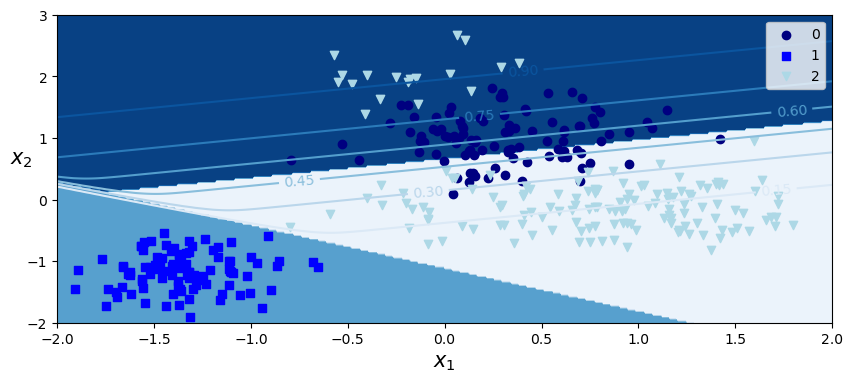

In [52]:
x0, x1 = np.meshgrid(np.linspace(-2, 2, 500).reshape(-1, 1),
                     np.linspace(-3, 3, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 0].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.contourf(x0, x1, zz, cmap='Blues_r')
contour = plt.contour(x0, x1, zz1, cmap="Blues")
plt.clabel(contour, inline=1)
plot_dataset()
plt.legend(loc="upper right")
plt.axis([-2, 2, -2, 3])

Our model is still underfitting the data but we expect a slightly better performance.

In [53]:
logits = X_valid_bias @ theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy = (y_predict == y_valid).mean()
accuracy

0.8863636363636364

We should not be satisfied with such a score since the model takes almost no account of outliers of class 2 at the top of the data set. Let's test it anyway.

In [54]:
logits = X_test_bias @ theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy = (y_predict == y_test).mean() # = accuracy_score(y_test,y_predict)
accuracy

0.8636363636363636

The previous result can be explained by the fact that this model is wrong only when it predicts the class of an outlier of class 2 (on the top of the dataset). Since there are only 18 such outliers in the entire dataset, there are only very few in the test data. The model therefore has little opportunity to be wrong. We can retain that a halfway good model should have a minimum score of 0.9 (this is a necessary but not sufficient condition).

<div class="alert alert-block alert-info">
<b>Score.</b> 
    0.86
</div>

<p style="text-align: justify;">
Some classification metrics are essentially defined for binary classification tasks. In extending a binary metric to multiclass or multilabel problems, the data is treated as a collection of binary problems, one for each class. There are then a number of ways to average binary metric calculations across the set of classes, each of which may be useful in some scenario. Where available, you should select among these using the <code>average</code> parameter. 
</p>

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

<p style="text-align: justify;">
Here we will use <code>"micro"</code> which gives each sample-class pair an equal contribution to the overall metric. Rather than summing the metric per class, this sums the dividends and divisors that make up the per-class metrics to calculate an overall quotient. Micro-averaging may be preferred in multilabel settings, including multiclass classification where a majority class is to be ignored.
</p>

$$\mathrm{precision}_{\text{micro}}=\frac{\sum_{c=1}^C TP_c}{\sum_{c=1}^C TP_c+FP_c}\qquad \mathrm{recall}_{\text{micro}}=\frac{\sum_{c=1}^C TP_c}{\sum_{c=1}^C TP_c+FN_c}$$

Let's extend the Precision Recall curve to multiclass classification by using [this reference](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.). 


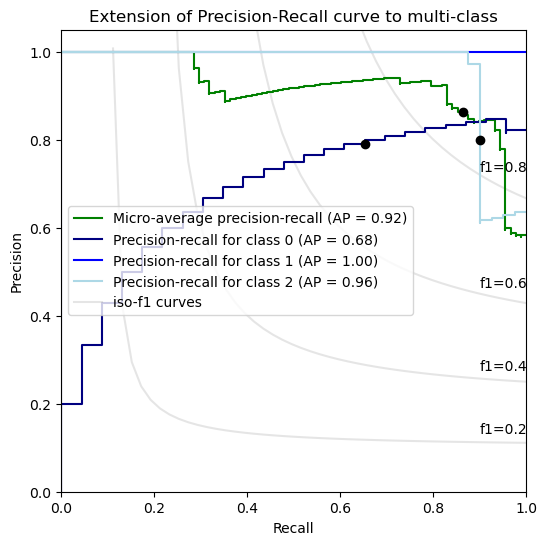

In [55]:
softmax_reg = LogisticRegression(C=1e7, random_state=seed)
softmax_reg.fit(X_train, y_train)

from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import PrecisionRecallDisplay

# Use label_binarize to be multi-label like settings
Y_train = label_binarize(y_train, classes=[0, 1, 2])
Y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = Y_train.shape[1]

# Y_score = softmax_reg.decision_function(X_test)
Y_score = Y_proba

# For each class
precision = dict()
recall = dict()
threshold = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], threshold[i] = precision_recall_curve(Y_test[:, i], Y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_score[:, i])
    
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], threshold_micro = precision_recall_curve(
    Y_test.ravel(), Y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, Y_score, average="micro")


# setup plot details
colors = cycle(["navy", "blue", "lightblue", "cornflowerblue", "green"])

_, ax = plt.subplots(figsize=(6, 6))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score) # precision = F_1*recall / (2*recall - F1)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="green")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")
plt.plot(recall[0][np.abs(threshold[0] - 0.5).argmin()], precision[0][np.abs(threshold[0] - 0.5).argmin()], marker="o", color="black")
plt.plot(recall[2][np.abs(threshold[2] - 0.5).argmin()], precision[2][np.abs(threshold[2] - 0.5).argmin()], marker="o", color="black")
plt.plot(accuracy, accuracy, marker="o", color="black")

In [56]:
cm = confusion_matrix(y_test,y_predict)
cm

array([[15,  0,  8],
       [ 0, 25,  0],
       [ 4,  0, 36]], dtype=int64)

- $FP_0=4$ elements of class 2 have been (badly) predicted as belonging to class 0
- $FP_2=8$ elements of class 0 have been (badly) predicted as belonging to class 2

Let's find in three different ways the values of precision and recall of our model for the class 0.

In [57]:
# Precision
print(precision[0][np.abs(threshold[0] - 0.5).argmin()])
print(precision_score(y_test, y_predict, labels=[0], average="micro"))
print(cm[0,0]/(cm[0,0]+cm[2,0])) # TP_0 / (TP_0 + FP_0)
# Recall
print(recall[0][np.abs(threshold[0] - 0.5).argmin()])
print(recall_score(y_test, y_predict, labels=[0], average="micro"))
print(cm[0,0]/(cm[0,0]+cm[0,2])) # TP_0 / (TP_0 + FN_0)

0.7894736842105263
0.7894736842105263
0.7894736842105263
0.6521739130434783
0.6521739130434783
0.6521739130434783


Let's find in two different ways the values of ```"micro"```-average precision of our model for classes 0 and 2.

In [58]:
print(recall_score(y_test, y_predict, labels=[0,2], average="micro"))
print((cm[0,0]+cm[2,2])/(cm[0,0]+cm[2,2]+cm[2,0]+cm[0,2])) # TP_0 + TP_2 / (TP_0 + TP_2 + FP_0 + FP_2)

0.8095238095238095
0.8095238095238095


If all labels are included, ```"micro"```-averaging in a multiclass setting will produce precision and recall that are all identical to accuracy.

In [59]:
print(precision["micro"][np.abs(threshold_micro - 0.5).argmin()])
print(precision_score(y_test, y_predict, average="micro"))
print(recall["micro"][np.abs(threshold_micro - 0.5).argmin()])
print(recall_score(y_test, y_predict, average="micro"))
print(accuracy)
print((cm[0,0]+cm[1,1]+cm[2,2])/(cm[0,0]+cm[1,1]+cm[2,2]+cm[2,0]+cm[0,2]))

0.8636363636363636
0.8636363636363636
0.8636363636363636
0.8636363636363636
0.8636363636363636
0.8636363636363636


## 3.2    Model 2 $-$ SVM classification <a class="anchor" id="section_3_2"></a>

Let's put the validation set back into the train set.

In [60]:
X_train = np.concatenate([X_train, X_valid], axis=0)
y_train = np.concatenate([y_train, y_valid], axis=0)

In [61]:
from scipy.stats import loguniform, uniform
from sklearn.svm import SVC

poly_kernel_svm_clf = SVC(random_state=seed, probability=True)

param_distributions = {
    'C': loguniform(1e0, 1e4),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': list(range(1,6)),
    'gamma': loguniform(0.001, 1),
    'coef0': uniform(-1, 1e2)
}

rnd_search = RandomizedSearchCV(poly_kernel_svm_clf, param_distributions, n_iter=100,
                                cv=5, random_state=seed, n_jobs=-1, scoring='accuracy')

In [62]:
rnd_search.fit(X_train, y_train)
rnd_search.best_estimator_

SVC(C=142.94554737163529, coef0=6.556640450523078, degree=2,
    gamma=0.019980339891949712, probability=True, random_state=3)

(-2.0, 2.0, -2.0, 3.0)

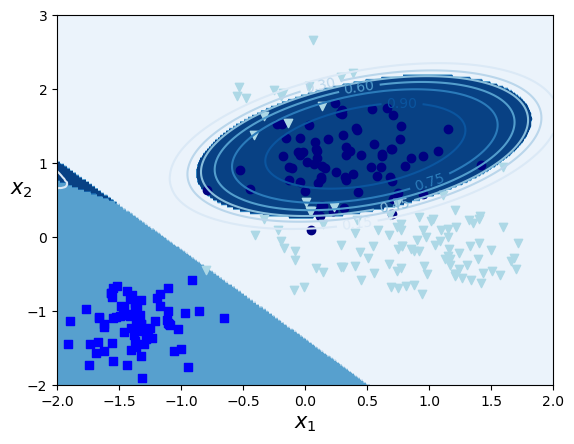

In [63]:
x0, x1 = np.meshgrid(np.linspace(-2, 2, 500).reshape(-1, 1),
                     np.linspace(-3, 3, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

Y_proba = rnd_search.predict_proba(X_new)
y_predict = rnd_search.predict(X_new)

zz1 = Y_proba[:, 0].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.contourf(x0, x1, zz, cmap='Blues_r')
contour = plt.contour(x0, x1, zz1, cmap="Blues")
plt.clabel(contour, inline=1)
plot_train_dataset()
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15, rotation=0)
plt.axis([-2, 2, -2, 3])

In [64]:
rnd_search.best_score_

0.9504354136429608

In [65]:
y_predict = rnd_search.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_predict))

[[22  0  1]
 [ 0 25  0]
 [ 0  0 40]]


In [66]:
rnd_search.best_estimator_.score(X_test, y_test)

0.9886363636363636

<div class="alert alert-block alert-info">
<b>Score.</b> 
    0.99
</div>

That's much better!

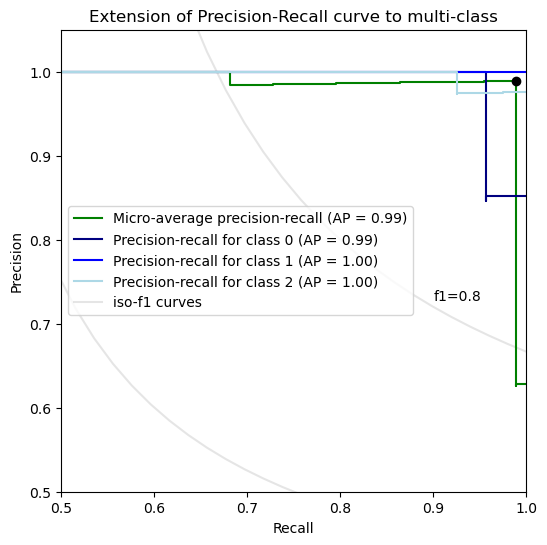

In [67]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import PrecisionRecallDisplay

# Use label_binarize to be multi-label like settings
Y_train = label_binarize(y_train, classes=[0, 1, 2])
Y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = Y_train.shape[1]

Y_score = rnd_search.best_estimator_.decision_function(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], Y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_score[:, i])
    
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), Y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, Y_score, average="micro")


# setup plot details
colors = cycle(["navy", "blue", "lightblue", "cornflowerblue", "green"])

_, ax = plt.subplots(figsize=(6, 6))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="green")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")
plt.plot(rnd_search.best_estimator_.score(X_test, y_test), rnd_search.best_estimator_.score(X_test, y_test), marker="o", color="black")

## 3.3    Overview of $k$-Nearest Neighbors and DecisionTreeClassifier <a class="anchor" id="section_3_3"></a>

Let's add without details $k$-Nearest Neighbors and DecisionTreeClassifier models.

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4, random_state=42)
0.9237199582027168
{'n_neighbors': 12, 'weights': 'uniform'}
0.9504354136429608


C:\Users\ducvi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


(-2.0, 3.0)

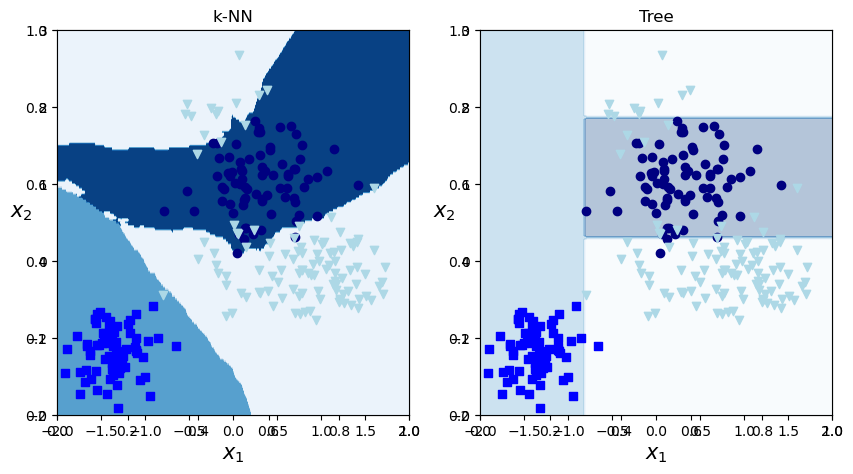

In [68]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              params,
                              cv=3)

grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_score_)

#

from sklearn.neighbors import KNeighborsClassifier

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance']
    }
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    warnings.filterwarnings("default")
    
    
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Tracer les frontières de décision du modèle 1
axs[0] = fig.add_subplot(121)
x0, x1 = np.meshgrid(np.linspace(-2, 2, 500).reshape(-1, 1),
                     np.linspace(-3, 3, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

Y_proba = grid_search.predict_proba(X_new)
y_predict = grid_search.predict(X_new)
zz1 = Y_proba[:, 0].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

axs[0].contourf(x0, x1, zz, cmap='Blues_r')
plot_train_dataset()
plt.title('k-NN')
axs[0].set_xlabel("$x_1$", fontsize=15)
axs[0].set_ylabel("$x_2$", fontsize=15, rotation=0)
axs[0].set_xlim([-2, 2])
axs[0].set_ylim([-2, 3])


# Tracer les frontières de décision du modèle 2
axs[1] = fig.add_subplot(122)
lengths, widths = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 3, 100))
X_new = np.c_[lengths.ravel(), widths.ravel()]
y_pred = grid_search_cv.best_estimator_.predict(X_new).reshape(lengths.shape)

axs[1].contourf(lengths, widths, y_pred, alpha=0.3, cmap='Blues_r')
plot_train_dataset()
plt.title('Tree')
axs[1].set_xlabel("$x_1$", fontsize=15)
axs[1].set_ylabel("$x_2$", fontsize=15, rotation=0)
axs[1].set_xlim([-2, 2])
axs[1].set_ylim([-2, 3])

<div class="alert alert-block alert-info">
<b>Score.</b> 
    0.92
</div>

<div class="alert alert-block alert-info">
<b>Score.</b> 0.95
</div>

# 4    Clustering <a class="anchor" id="chapter4"></a>

## 4.1    $K$-Means Clustering <a class="anchor" id="section_4_1"></a>

The $K$-means algorithm, implemented in ```sklearn.cluster.KMeans``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)), clusters data by trying to separate samples in groups of equal variance. More precisely it divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster **centroids**; note that they are not, in general, points from $X$, although they live in the same space. The $K$-means algorithm aims to choose centroids that minimise a criterion known as the inertia or within-cluster sum-of-squares. 

<div class="alert alert-block alert-warning">
<b>Definition.</b> <br> 
    The <b>inertia</b> or <b>within-cluster sum-of-squares</b> is mean squared distance between each instance and its closest centroid.
    $$\sum_{i=0}^n \min_{\mu_j\in C}\|x_i-\mu_j\|^2$$
</div>

$K$-means is often referred to as Lloyd’s algorithm. In basic terms, the algorithm (by default ```algorithm='lloyd'```) has three steps. 

<ul>
    <li>The first step chooses the initial centroids (by default <code>init='k-means++'</code> tends to select centroids that are distant from one another, it may avoid convergence to a local minimum so leads to probably better results than random initialization).</li>
 <li>After initialization, $K$-means consists of looping between the two other steps. 
        <ul>
            <li> The first step assigns each sample to its nearest centroid. </li>
            <li> The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. </li>
        </ul>
    </li>
</ul> 

The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/clustering.html#k-means).

The 3 classes were created in a very twisted way, it would not make sense to try to find these classes. What might be more interesting is to find out how the data was generated, *i.e.* to identify the 5 blobs created by the ```make_blob``` generator. As our clusters are convex and isotropic we can use inertia (which responds poorly to elongated clusters, or manifolds with irregular shape).

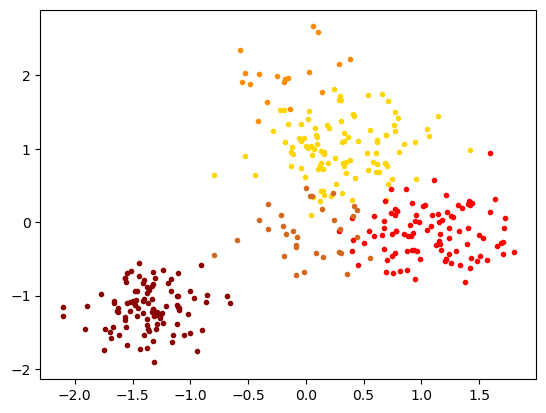

In [69]:
X_gene = scaler.transform(X_gene)
new_X = scaler.transform(new_X)
plt.scatter(X_gene[y_gene == 0, 0], X_gene[y_gene == 0, 1], marker='.', color = 'gold')
plt.scatter(X_gene[y_gene == 1, 0], X_gene[y_gene == 1, 1], marker='.', color='darkred')
plt.scatter(X_gene[y_gene == 2, 0], X_gene[y_gene == 2, 1], marker='.', color='red')
plt.scatter(new_X[new_y == 0, 0], new_X[new_y == 0, 1], marker='.', color='darkorange')
plt.scatter(new_X[new_y == 1, 0], new_X[new_y == 1, 1], marker='.', color='chocolate')

Unlike classification, clustering is an unsupervised task. In this context, an
instance’s label is the index of the cluster that this instance gets assigned to by the
algorithm: this is not to be confused with the class labels in classification. Let's remove the labels.

Text(0, 0.5, '$x_2$')

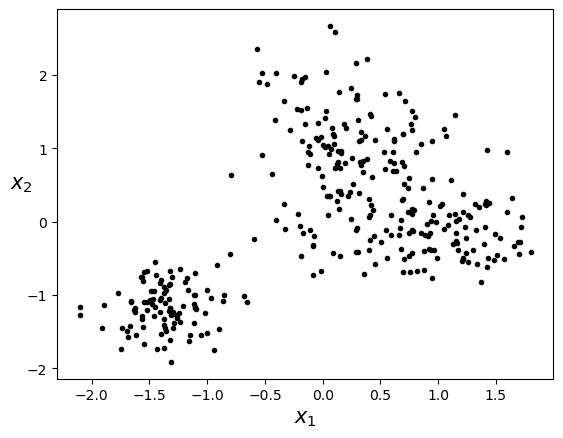

In [70]:
plt.scatter(X[:, 0], X[:, 1], c="k", marker=".")
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15, rotation=0)

At first we will assume the number of clusters 5 is known. But it is not obvious from looking at the data that $k$ should be set to 5. We will discuss this in a second part.

### 4.1.1 Number of clusters given <a class="anchor" id="section_4_1_1"></a>

Let's first specify the number of clusters $k=5$ that the algorithm must find. Let’s train a $K$-Means clusterer on this dataset. It will try to find each blob’s center and assign each instance to the closest blob. Let's take a look at the five centroids that the algorithm found:

In [71]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=seed) # bby default, init='k-means++', algorithm='lloyd'
y_pred = kmeans.fit_predict(X)
print('kmeans inertia : ', kmeans.inertia_)
print('kmeans score : ', kmeans.score(X))
centroids = kmeans.cluster_centers_
print('Centroids : \n', centroids)

kmeans inertia :  68.82667846071679
kmeans score :  -68.82667846071679
Centroids : 
 [[-1.35722157 -1.1616818 ]
 [ 0.12031816 -0.02801707]
 [ 1.13589167 -0.14429595]
 [-0.05480757  1.81495512]
 [ 0.38521112  0.99507968]]


Recall the actual standardized centers.

In [72]:
print(scaler.transform(centers)[1])
print(scaler.transform(new_center)[1])
print(scaler.transform(centers)[2])
print(scaler.transform(new_center)[0])
print(scaler.transform(centers)[0])

[-1.39602376 -1.16471188]
[ 0.09837297 -0.16349081]
[ 1.06533556 -0.16349081]
[-0.1653441   2.08925662]
[0.36209004 1.00460045]


Let's plot the cluster’s decision boundaries where each centroid is represented with a black point. Most points have been assigned to the right cluster.

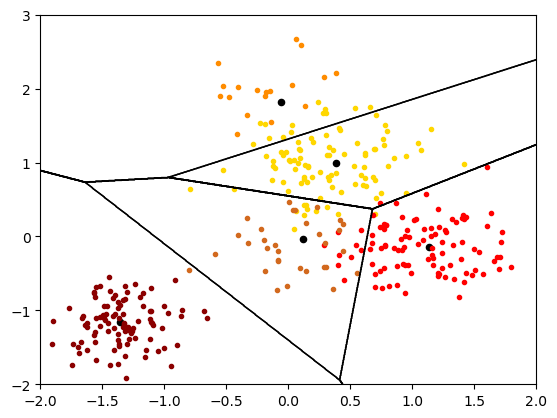

In [73]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 1000), 
                         np.linspace(-2, 3, 1000))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contour(Z, extent=(-2, 2, -2, 3), linewidths=1, colors='k')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=20, color='k')
plt.axis([-2, 2, -2, 3])
plt.scatter(X_gene[y_gene == 0, 0], X_gene[y_gene == 0, 1], marker='.', color = 'gold')
plt.scatter(X_gene[y_gene == 1, 0], X_gene[y_gene == 1, 1], marker='.', color='darkred')
plt.scatter(X_gene[y_gene == 2, 0], X_gene[y_gene == 2, 1], marker='.', color='red')
plt.scatter(new_X[new_y == 0, 0], new_X[new_y == 0, 1], marker='.', color='darkorange')
plt.scatter(new_X[new_y == 1, 0], new_X[new_y == 1, 1], marker='.', color='chocolate')

Let's try the Mini-Batch $K$-Means clustering. As often its inertia is slightly worse.

In [74]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(n_clusters=5, random_state=seed)
mbk.fit(X)

C:\Users\ducvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=3)

[]

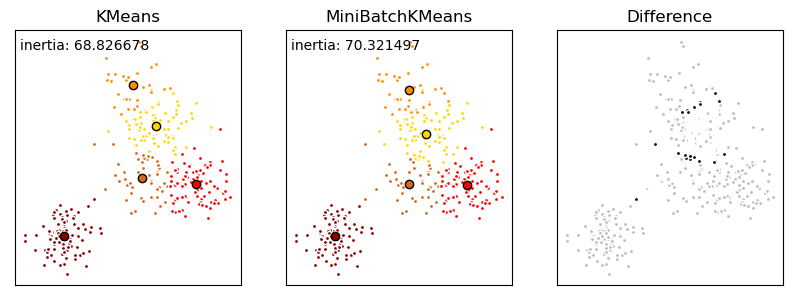

In [75]:
from sklearn.cluster import MiniBatchKMeans
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", message="MiniBatchKMeans is known to have a memory leak on Windows with MKL")

k_means=kmeans

mbk = MiniBatchKMeans(n_clusters=5, random_state=seed)
mbk.fit(X)
mbk.inertia_

import time

batch_size = 45
n_clusters=5

from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['darkred', 'chocolate', 'red', 'darkorange', 'gold']

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-2.2, 2.5, "inertia: %f" % k_means.inertia_)

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-2.2, 2.5, "inertia: %f" % mbk.inertia_)

# Initialize the different array to all False
different = mbk_means_labels == 6
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="k", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

### 4.1.2 Number of clusters not given <a class="anchor" id="section_4_1_2"></a>

In general the number of clusters $k$ is unknown. Choosing the wrong value of $k$ can quickly lead to poor performance. 

#### 4.1.2.1 Inertia as a function of $k$ <a class="anchor" id="section_4_1_2_1"></a>

When selecting a value for $k$, inertia is an unsuitable metric in the sense that it is not relevant to choose the $k$ that minimizes the inertia. Indeed as the number of clusters $k$ increases, the instances are closer to their respective centroids, resulting in lower inertia. So we would always have to choose an infinitely large value of $k$. However, a rather crude technique, consisting in plotting the evolution of the inertia as a function of $k$ is sometimes used. Let's implement it.

C:\Users\ducvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


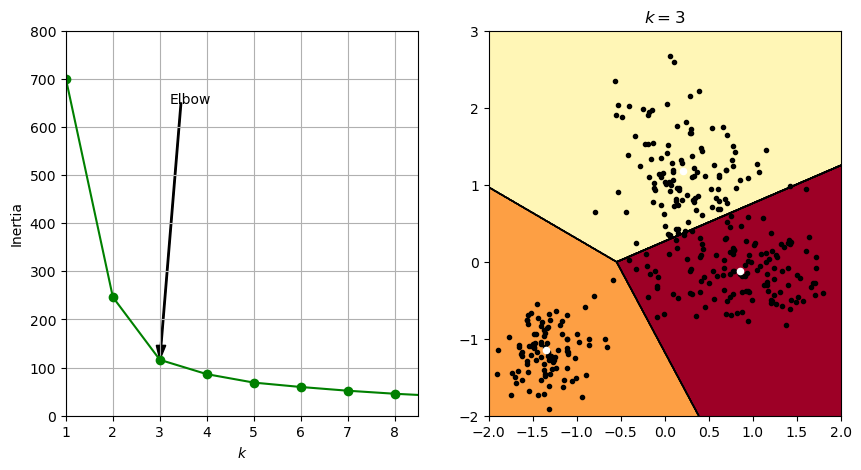

In [76]:
import warnings

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot 1
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

axes[0].plot(range(1, 10), inertias, "go-")
axes[0].set_xlabel("$k$")
axes[0].set_ylabel("Inertia")
axes[0].arrow(3.45, 650, -0.45, inertias[2]-650, width=0.03, head_width=0.2, head_length=30, length_includes_head=True, color='black')
axes[0].text(3.2, 650, "Elbow")
axes[0].axis([1, 8.5, 0, 800])
axes[0].grid()

# Plot 2
three_means = KMeans(n_clusters=3, random_state=seed)
three_means.fit(X)
three_means_centroids = three_means.cluster_centers_
xx, yy = np.meshgrid(np.linspace(-2, 2, 1000), np.linspace(-2, 3, 1000))
Z = three_means.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[1].contourf(Z, extent=(-2, 2, -2, 3), cmap='YlOrRd')
axes[1].contour(Z, extent=(-2, 2, -2, 3), linewidths=1, colors='k')
axes[1].scatter(X[:, 0], X[:, 1], c='k', marker='.')
axes[1].scatter(three_means_centroids[:, 0], three_means_centroids[:, 1], marker='o', s=20, color='w')
axes[1].axis([-2, 2, -2, 3])
axes[1].set_title(r'$k=3$')

warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

This graph shows a rapid drop in inertia up to $k=3$ clusters, but then the decrease slows down as the number of clusters increases. Any value lower than $k=3$ would result in a significant loss of information, while any higher value than $k=3$ would only marginally improve results and might needlessly split clusters. This technique does not lead here to the right value of $k$.

#### 4.1.2.2 Silhouette score <a class="anchor" id="section_4_1_2_2"></a>

The Silhouette Coefficient, implemented in ```sklearn.metrics.silhouette_samples``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#sklearn.metrics.silhouette_samples)), is a measure of how well samples are clustered with samples that are similar to themselves. 

<div class="alert alert-block alert-warning">
<b>Definition.</b> <br> 
    The <b>Silhouette Coefficient</b>, denoted $s$, is defined for each sample by
$$s=\frac{b-a}{\max\{a,b\}}$$
where
<ul>
 <li>$a$ : the mean distance between a sample and all other points in the same class.</li>
 <li>$b$ : the mean distance between a sample and all other points in the next nearest cluster.</li>
 </ul>
</div>


The silhouette coefficient can vary between $–1$ and $+1$. The best value is $1$ and the worst value is $-1$. 
- A coefficient close to $+1$ means that the instance is well inside its own cluster and far from other clusters
- A coefficient close to $0$ means that it is close to a cluster boundary (overlapping clusters)
- A coefficient close to $–1$ means that the instance may have been assigned to the wrong cluster.

<div class="alert alert-block alert-warning">
<b>Definition.</b> <br> 
    The <b>Silhouette Score</b> is the mean Silhouette Coefficient over all samples.
</div>

The Silhouette Score is implemented in ```sklearn.metrics.silhouette_score``` ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)).


A higher Silhouette Score relates to a model with better defined clusters. Clustering models with a high Silhouette Score are said to be **dense**, where samples in the same cluster are similar to each other, and **well separated**, where samples in different clusters are not very similar to each other.

> See more information in Scikit-Learn [User Guide](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient).


In [77]:
kmeans.labels_[0:5]

array([2, 4, 2, 0, 0])

In [78]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.49368799048388123

Let’s compare the silhouette scores for different numbers of clusters.

(2.0, 8.5, 0.3, 0.7)

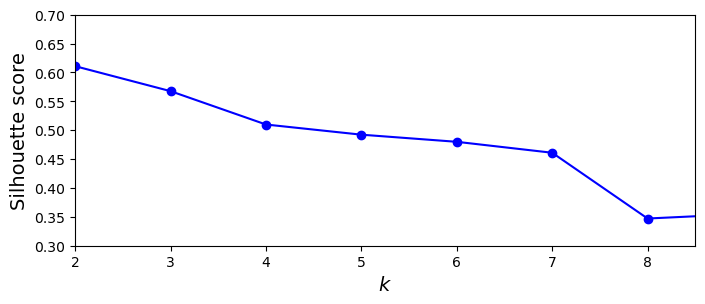

In [79]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([2, 8.5, 0.3, 0.7])

We do not observe a peak in the silhouette score for a certain value of $k$. Unfortunately this method does not work here either. Let's plot the silhouette diagramm ([see here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)). It's a plot of every instance’s
silhouette coefficient, sorted by the cluster they are assigned to and by the value of the
coefficient. The shape’s height indicates the number of instances
the cluster contains, and its width represents the sorted silhouette coefficients of the
instances in the cluster (wider is better).

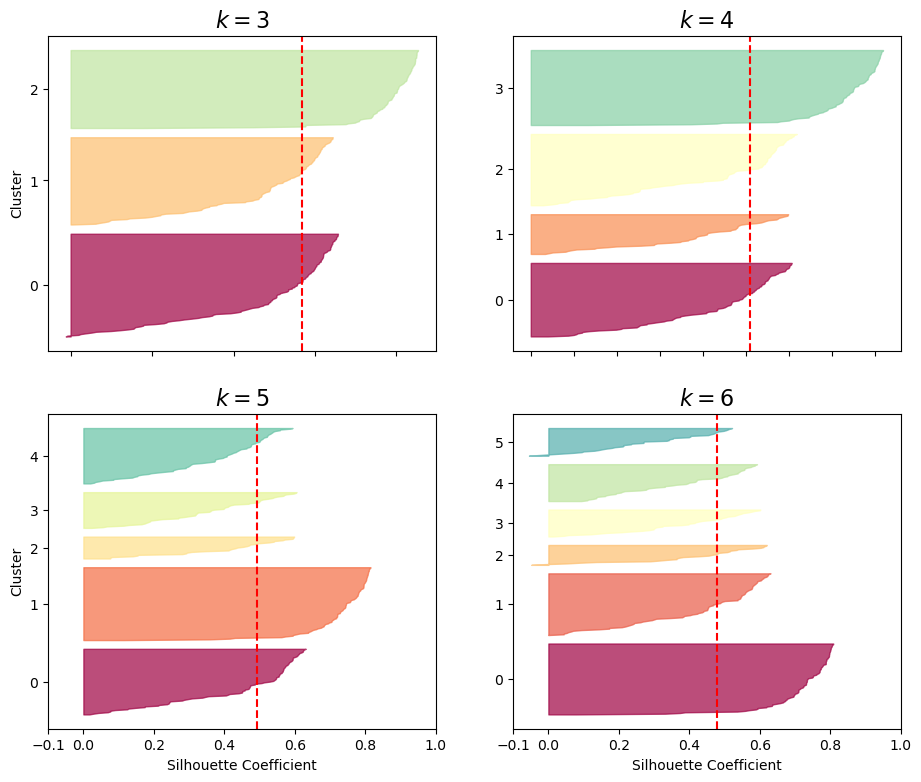

In [80]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. These graphs still do not allow us to determine $k$ here. The $K$-means clustering may not be adapted to this dataset. Indeed the clusters are not of the same size so we should rather try gaussian mixtures ([see here](https://scikit-learn.org/stable/modules/clustering.html)). 

## 4.2   Further consideration - Gaussian mixture <a class="anchor" id="section_4_2"></a>

We conclude this notebook by giving a representation of a gaussian mixture (with ```n_components=5```) without further explanation.

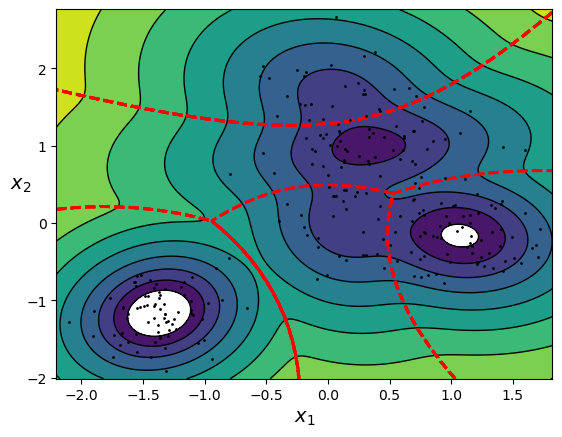

In [81]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

gm = GaussianMixture(n_components=5, n_init=10)
gm.fit(X_train)

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X_train[:, 0], X_train[:, 1], 'k.', markersize=2)
#     plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
        
plot_gaussian_mixture(gm, X_train)
